# CNN for Classification
---
In this notebook, we define **and train** an CNN to classify images from the [Fashion-MNIST database](https://github.com/zalandoresearch/fashion-mnist).

### Load the [data](http://pytorch.org/docs/master/torchvision/datasets.html)

In this cell, we load in both **training and test** datasets from the FashionMNIST class.

In [1]:
# our basic libraries
import torch
import torchvision

# data loading and transforming
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

# The output of torchvision datasets are PILImage images of range [0, 1]. 
# We transform them to Tensors for input into a CNN

## Define a transform to read the data in as a tensor
data_transform = transforms.ToTensor()

# choose the training and test datasets
train_data = FashionMNIST(root='/files/cedric/datasets/torchvision', train=True,
                                   download=True, transform=data_transform)

test_data = FashionMNIST(root='/files/cedric/datasets/torchvision', train=False,
                                  download=True, transform=data_transform)


# Print out some stats about the training and test data
print('Train data, number of images: ', len(train_data))
print('Test data, number of images: ', len(test_data))

Train data, number of images:  60000
Test data, number of images:  10000


In [2]:
# prepare data loaders, set the batch_size
## TODO: you can try changing the batch_size to be larger or smaller
## when you get to training your network, see how batch_size affects the loss
batch_size = 20

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Visualize some training data

This cell iterates over the training dataset, loading a random batch of image/label data, using `dataiter.next()`. It then plots the batch of images and labels in a `2 x batch_size/2` grid.

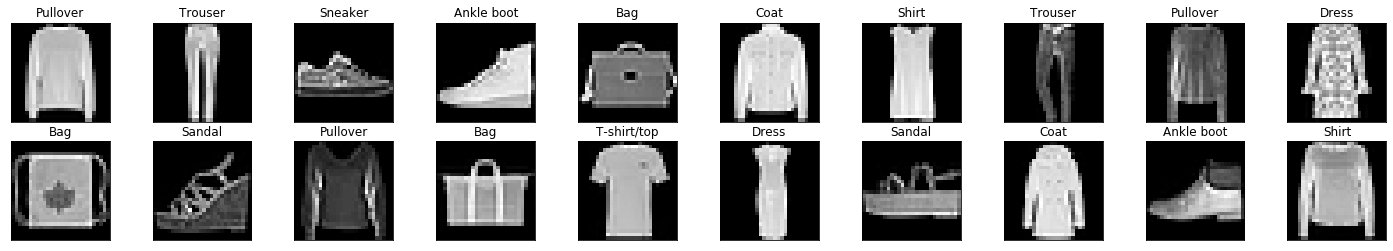

In [3]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

### Define the network architecture

The various layers that make up any neural network are documented, [here](http://pytorch.org/docs/master/nn.html). For a convolutional neural network, we'll use a simple series of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected (linear) layers

You are also encouraged to look at adding [dropout layers](http://pytorch.org/docs/stable/nn.html#dropout) to avoid overfitting this data.

---

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

You must place any layers with trainable weights, such as convolutional layers, in the `__init__` function and refer to them in the `forward` functio; any layers or functions that always behave in the same way, such as a pre-defined activation function, may appear in either the `__init__` or the `forward` function. In practice, you'll often see conv/pool layers defined in `__init__` and activations defined in `forward`.

#### Convolutional layer
The first convolution layer has been defined for you, it takes in a 1 channel (grayscale) image and outputs 10 feature maps as output, after convolving the image with 3x3 filters.

#### Flattening

Recall that to move from the output of a convoluttional/pooling layer to a linear layer, you must first flatten your extracted features into a vector. If you've used the deep learning library, Keras, you may have seen this done by `Flatten()`, and in PyTorch you can flatten an input `x` with `x = x.view(x.size(0), -1)`.

### TODO: Define the rest of the layers

It will be up to you to define the other layers in this network; we have some recommendations, but you may change the architecture and parameters as you see fit.

Recommendations/tips:
* Use at least two convolutional layers
* Your output must be a linear layer with 10 outputs (for the 10 classes of clothing)
* Use a dropout layer to avoid overfitting

In [208]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        # convolutional layer parameters (default values from Pytorch)
        # we do this to calculated output size of convolutional layer
        self.stride = 1
        self.padding = 0
        self.dilatation = 1
        self.in_channels = 1 # 1 input channel grayscale
        self.out_channels = 20
        self.kernel = 3
        
        # properties of max pool layers
        self.pool_stride = 2
        self.pool_kernel = 2
        self.pool_dilatation = 1
        self.pool_padding = 0
        
        # properties of training samples
        self.height = 28
        self.width = 28
        self.batch = 20
        self.nb_classes = 10
        
        # 1 input image channel (grayscale), 10 output channels/feature maps
        # 3x3 square convolution kernel
        self.conv1 = nn.Conv2d(self.in_channels, self.out_channels, self.kernel)
        self.shape_conv1 = (
            self.batch,
            self.out_channels,
            int((self.height + 2 * self.padding - self.dilatation * (self.kernel - 1) - 1) / self.stride + 1),
            int((self.width + 2 * self.padding - self.dilatation * (self.kernel - 1) - 1) / self.stride + 1),
        )
        
        ## TODO: Define the rest of the layers:
        # include another conv layer, maxpooling layers, and linear layers
        # also consider adding a dropout layer to avoid overfitting
        self.pool1 = nn.MaxPool2d(self.pool_kernel, self.pool_stride)
        self.shape_pool1 = (
            self.batch,
            self.out_channels,
            int((self.shape_conv1[2] + 2 * self.pool_padding - self.pool_dilatation * (self.pool_kernel - 1) - 1) / self.pool_stride + 1),
            int((self.shape_conv1[3] + 2 * self.pool_padding - self.pool_dilatation * (self.pool_kernel - 1) - 1) / self.pool_stride + 1),
        )  
        # we now have added channels so the number of input channels is different
        # we also now use twice the number of ouput channels (arbitrary)
        self.conv2 = nn.Conv2d(self.out_channels, self.out_channels * 2, self.kernel)
        self.shape_conv2 = (
            self.batch,
            self.out_channels * 2,
            int((self.shape_pool1[2] + 2 * self.padding - self.dilatation * (self.kernel - 1) - 1) / self.stride + 1),
            int((self.shape_pool1[3] + 2 * self.padding - self.dilatation * (self.kernel - 1) - 1) / self.stride + 1),
        )
        self.pool2 = nn.MaxPool2d(self.pool_kernel, self.pool_stride)
        self.shape_pool2 = (
            self.batch,
            self.out_channels * 2,
            int((self.shape_conv2[2] + 2 * self.pool_padding - self.pool_dilatation * (self.pool_kernel - 1) - 1) / self.pool_stride + 1),
            int((self.shape_conv2[3] + 2 * self.pool_padding - self.pool_dilatation * (self.pool_kernel - 1) - 1) / self.pool_stride + 1),
        )
        self.dropout = nn.Dropout(0.2)
        self.fcl = nn.Linear(self.shape_pool2[1] * self.shape_pool2[2] * self.shape_pool2[3], self.nb_classes)
        self.print_shapes = True
        

    ## TODO: define the feedforward behavior
    def forward(self, x):
        # one activated conv layer
        if self.print_shapes:
            print("Training data shape:")
            print("  ", x.shape)
            print("   images are 28x28, 1 channel (greyscale), and passed in batch of 20")
        x = self.conv1(x)
        if self.print_shapes:
            print("Shape after convolution layer 1:")
            print("  ", x.shape, self.shape_conv1)
        x = F.relu(x)
        if self.print_shapes:
            print("Shape after ReLU activation 1:")
            print("  ", x.shape, "does not change the shape")
        x = self.pool1(x)
        if self.print_shapes:
            print("Shape after max pool 1:")
            print("  ", x.shape, self.shape_pool1)        
        x = self.conv2(x)
        if self.print_shapes:
            print("Shape after convolution layer 2:")
            print("  ", x.shape, self.shape_conv2)
        x = F.relu(x)
        if self.print_shapes:
            print("Shape after ReLU activation 2:")
            print("  ", x.shape, "does not change the shape")        
        x = self.pool2(x)
        if self.print_shapes:
            print("Shape after max pool 2:")
            print("  ", x.shape, self.shape_pool2)                
        x = self.dropout(x)    
        if self.print_shapes:
            print("Shape after dropout layer:")
            print("  ", x.shape, "does not change the shape")
        x = torch.flatten(x, 1)
        if self.print_shapes:
            print("Shape after flatten:")
            print("  ", x.shape)
        x = self.fcl(x)
        
        # final output
        self.print_shapes = False
        return x

# instantiate and print your Net
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fcl): Linear(in_features=1000, out_features=10, bias=True)
)


### TODO: Specify the loss function and optimizer

Learn more about [loss functions](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizers](http://pytorch.org/docs/master/optim.html) in the online documentation.

Note that for a classification problem like this, one typically uses cross entropy loss, which can be defined in code like: `criterion = nn.CrossEntropyLoss()`. PyTorch also includes some standard stochastic optimizers like stochastic gradient descent and Adam. You're encouraged to try different optimizers and see how your model responds to these choices as it trains.


In [209]:
import torch.optim as optim

## TODO: specify loss function (try categorical cross-entropy)
#criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()

## TODO: specify optimizer 
optimizer = optim.Adam(net.parameters(), lr=0.001)

### A note on accuracy

It's interesting to look at the accuracy of your network **before and after** training. This way you can really see that your network has learned something. In the next cell, let's see what the accuracy of an untrained network is (we expect it to be around 10% which is the same accuracy as just guessing for all 10 classes).

#### Variable

Before an input tensor can be processed by a model, it must be wrapped in a Variable wrapper; this wrapper gives PyTorch the ability to automatically track how this input changes as it passes through the network and automatically calculate the gradients needed for backpropagation.


In [210]:
from torch.autograd import Variable

# Calculate accuracy before training
correct = 0
total = 0

# Iterate through test dataset
for images, labels in test_loader:
    
    # warp input images in a Variable wrapper
    images = Variable(images)

    # forward pass to get outputs
    # the outputs are a series of class scores
    outputs = net(images)

    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)

    # count up total number of correct labels
    # for which the predicted and true labels are equal
    total += labels.size(0)
    correct += (predicted == labels).sum()

# calculate the accuracy
accuracy = 100 * correct / total

# print it out!
print('Accuracy before training: ', float(accuracy))

Training data shape:
   torch.Size([20, 1, 28, 28])
   images are 28x28, 1 channel (greyscale), and passed in batch of 20
Shape after convolution layer 1:
   torch.Size([20, 20, 26, 26]) (20, 20, 26, 26)
Shape after ReLU activation 1:
   torch.Size([20, 20, 26, 26]) does not change the shape
Shape after max pool 1:
   torch.Size([20, 20, 13, 13]) (20, 20, 13, 13)
Shape after convolution layer 2:
   torch.Size([20, 40, 11, 11]) (20, 40, 11, 11)
Shape after ReLU activation 2:
   torch.Size([20, 40, 11, 11]) does not change the shape
Shape after max pool 2:
   torch.Size([20, 40, 5, 5]) (20, 40, 5, 5)
Shape after dropout layer:
   torch.Size([20, 40, 5, 5]) does not change the shape
Shape after flatten:
   torch.Size([20, 1000])
Accuracy before training:  9.0


### Train the Network

Below, we've defined a `train` function that takes in a number of epochs to train for. The number of epochs is how many times a network will cycle through the training dataset. 

Here are the steps that this training function performs as it iterates over the training dataset:

1. Wraps all tensors in Variables
2. Zero's the gradients to prepare for a forward pass
3. Passes the input through the network (forward pass)
4. Computes the loss (how far is the predicted classes are from the correct labels)
5. Propagates gradients back into the network’s parameters (backward pass)
6. Updates the weights (parameter update)
7. Prints out the calculated loss



In [211]:
from torch.autograd import Variable

def train(n_epochs):
    
    loss_over_time = [] # to track the loss as the network trains
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            inputs, labels = data

            # wrap them in a torch Variable
            inputs, labels = Variable(inputs), Variable(labels)        

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            outputs = net(inputs)

            # calculate the loss
            loss = criterion(outputs, labels)

            # backward pass to calculate the parameter gradients
            loss.backward()

            # update the parameters
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 1000 == 999:    # print every 1000 mini-batches
                avg_loss = running_loss/1000
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training')
    return loss_over_time


In [212]:
# define the number of epochs to train for
n_epochs = 30 # start small to see if your model works, initially

# call train
loss_over_time = train(n_epochs)

Epoch: 1, Batch: 1000, Avg. Loss: 0.6483960962295532
Epoch: 1, Batch: 2000, Avg. Loss: 0.4520049219913781
Epoch: 1, Batch: 3000, Avg. Loss: 0.4086056775785983
Epoch: 2, Batch: 1000, Avg. Loss: 0.38284872613847254
Epoch: 2, Batch: 2000, Avg. Loss: 0.3617652833610773
Epoch: 2, Batch: 3000, Avg. Loss: 0.35666587453708054
Epoch: 3, Batch: 1000, Avg. Loss: 0.3326109027899802
Epoch: 3, Batch: 2000, Avg. Loss: 0.33348121937550607
Epoch: 3, Batch: 3000, Avg. Loss: 0.3221375811100006
Epoch: 4, Batch: 1000, Avg. Loss: 0.3105428866837174
Epoch: 4, Batch: 2000, Avg. Loss: 0.3045759473666549
Epoch: 4, Batch: 3000, Avg. Loss: 0.30294981920719144
Epoch: 5, Batch: 1000, Avg. Loss: 0.2901927678342909
Epoch: 5, Batch: 2000, Avg. Loss: 0.289050761366263
Epoch: 5, Batch: 3000, Avg. Loss: 0.2916529361307621
Epoch: 6, Batch: 1000, Avg. Loss: 0.27339436851628124
Epoch: 6, Batch: 2000, Avg. Loss: 0.27462001523468643
Epoch: 6, Batch: 3000, Avg. Loss: 0.28037310344725846
Epoch: 7, Batch: 1000, Avg. Loss: 0.2621

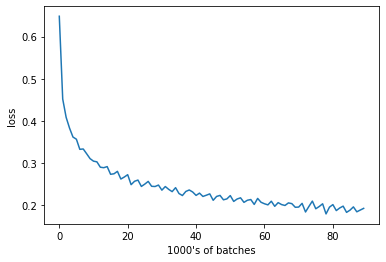

In [213]:
# visualize the loss as the network trained
plt.plot(loss_over_time)
plt.xlabel('1000\'s of batches')
plt.ylabel('loss')
#plt.ylim(0, 2.5) # consistent scale
plt.show()

### Test the Trained Network

Once you are satisfied with how the loss of your model has decreased, there is one last step: test!

You must test your trained model on a previously unseen dataset to see if it generalizes well and can accurately classify this new dataset. For FashionMNIST, which contains many pre-processed training images, a good model should reach **greater than 85% accuracy** on this test dataset. If you are not reaching this value, try training for a larger number of epochs, tweaking your hyperparameters, or adding/subtracting layers from your CNN.

In [214]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# set the module to evaluation mode
net.eval()

for batch_i, data in enumerate(test_loader):
    
    with torch.no_grad():
        # get the input images and their corresponding labels
        inputs, labels = data

        # wrap them in a torch Variable
        # volatile means we do not have to track how the inputs change
        inputs, labels = Variable(inputs), Variable(labels)

        # forward pass to get outputs
        outputs = net(inputs)

        # calculate the loss
        loss = criterion(outputs, labels)

        # update average test loss 
        test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.item() - test_loss))

        # get the predicted class from the maximum value in the output-list of class scores
        _, predicted = torch.max(outputs.data, 1)

        # compare predictions to true label
        correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))

        # calculate test accuracy for *each* object class
        # we get the scalar value of correct items for a class, by calling `correct[i].item()`
        for i in range(batch_size):
            label = labels.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

        # calculate test accuracy for *each* object class
        for i in range(batch_size):
            label = labels.data[i]
            class_correct[label] += correct[i]
            class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(float(class_correct[i])), np.sum(float(class_total[i]))))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.276903

Test Accuracy of T-shirt/top: 85% (1704/2000)
Test Accuracy of Trouser: 98% (1960/2000)
Test Accuracy of Pullover: 90% (1800/2000)
Test Accuracy of Dress: 88% (1776/2000)
Test Accuracy of  Coat: 86% (1730/2000)
Test Accuracy of Sandal: 97% (1950/2000)
Test Accuracy of Shirt: 70% (1408/2000)
Test Accuracy of Sneaker: 97% (1942/2000)
Test Accuracy of   Bag: 98% (1960/2000)
Test Accuracy of Ankle boot: 95% (1918/2000)

Test Accuracy (Overall): 90% (18148/20000)


### Visualize sample test results

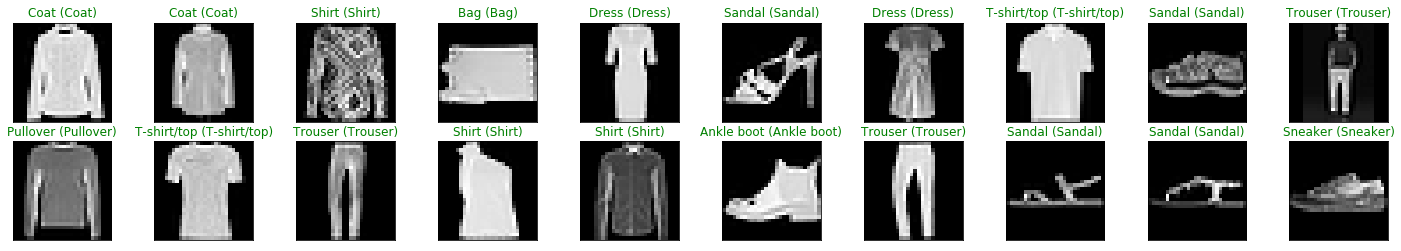

In [215]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
# get predictions
with torch.no_grad():
    preds = np.squeeze(net(Variable(images)).data.max(1, keepdim=True)[1].numpy())
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

### Question: What are some weaknesses of your model? (And how might you improve these in future iterations.)

**Answer**: The accuracy on shirts is significantly lower than for any other classes. This would probably require more tuning of the hyperparameters.

### Save Your Best Model

Once you've decided on a network architecture and are satisfied with the test accuracy of your model after training, it's time to save this so that you can refer back to this model, and use it at a later data for comparison of for another classification task!

In [219]:
## TODO: change the model_name to something uniqe for any new model
## you wish to save, this will save it in the saved_models directory
model_dir = 'saved_models/'
model_name = 'model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
# when you're ready, un-comment the line below
!mkdir -p saved_models
torch.save(net.state_dict(), model_dir+model_name)

### Load a Trained, Saved Model

To instantiate a trained model, you'll first instantiate a new `Net()` and then initialize it with a saved dictionary of parameters (from the save step above).

In [220]:
# instantiate your Net
# this refers to your Net class defined above
net = Net()

# load the net parameters by name
# uncomment and write the name of a saved model
net.load_state_dict(torch.load('saved_models/model_1.pt'))

print(net)

# Once you've loaded a specific model in, you can then 
# us it or further analyze it! 
# This will be especialy useful for feature visualization 

Net(
  (conv1): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fcl): Linear(in_features=1000, out_features=10, bias=True)
)
